1. CNN for problem 1.

In [1]:
#Load nessesary libraries, remember to import drive when using colab

import os
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import hashlib
from tensorflow.keras.layers import (Input, Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling2D, DepthwiseConv2D, Add, Multiply, BatchNormalization, ReLU, MaxPooling2D, Activation, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness, RandomContrast)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.data import AUTOTUNE
from google.colab import drive
import cv2
from PIL import Image



In [2]:
#for Colab filepath:
drive.mount('/content/drive/')
filepath = '/content/drive/My Drive/DS807'



Mounted at /content/drive/


In [3]:
# Loading the saved datasets when on Google Colab
tf_train = tf.data.experimental.load(f'{filepath}/train')
tf_validation = tf.data.experimental.load(f'{filepath}/validation')
tf_test = tf.data.experimental.load(f'{filepath}/test')

# Print the number of elements in each dataset
train_size = tf.data.experimental.cardinality(tf_train).numpy()
validation_size = tf.data.experimental.cardinality(tf_validation).numpy()
test_size = tf.data.experimental.cardinality(tf_test).numpy()

print(f"Number of images in the training dataset: {train_size}")
print(f"Number of images in the validation dataset: {validation_size}")
print(f"Number of images in the test dataset: {test_size}")

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


Number of images in the training dataset: 916
Number of images in the validation dataset: 114
Number of images in the test dataset: 29


In [4]:
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset_224 = tf_train.map(preprocess_image)
validation_dataset_224 = tf_validation.map(preprocess_image)
test_dataset_224 = tf_test.map(preprocess_image)


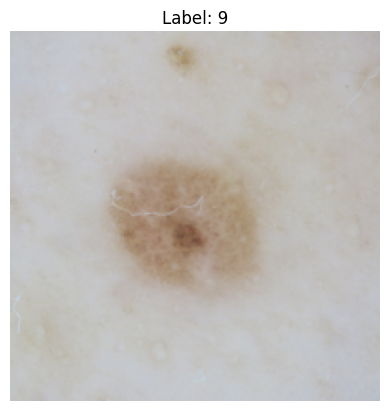

In [5]:
# It should yield image-label pairs

#plotting image
for image, label in train_dataset_224.take(1):
    if image.dtype.is_floating:
        image = tf.clip_by_value(image, 0.0, 1.0)
    elif image.dtype.is_integer:
        image = tf.clip_by_value(image, 0, 255)

    # Converting to numpy for display
    image = image.numpy()

    # Plot the image
    plt.imshow(image[0])  # Assuming the dataset has batches
    plt.title(f"Label: {label[0].numpy()}")
    plt.axis("off")
    plt.show()

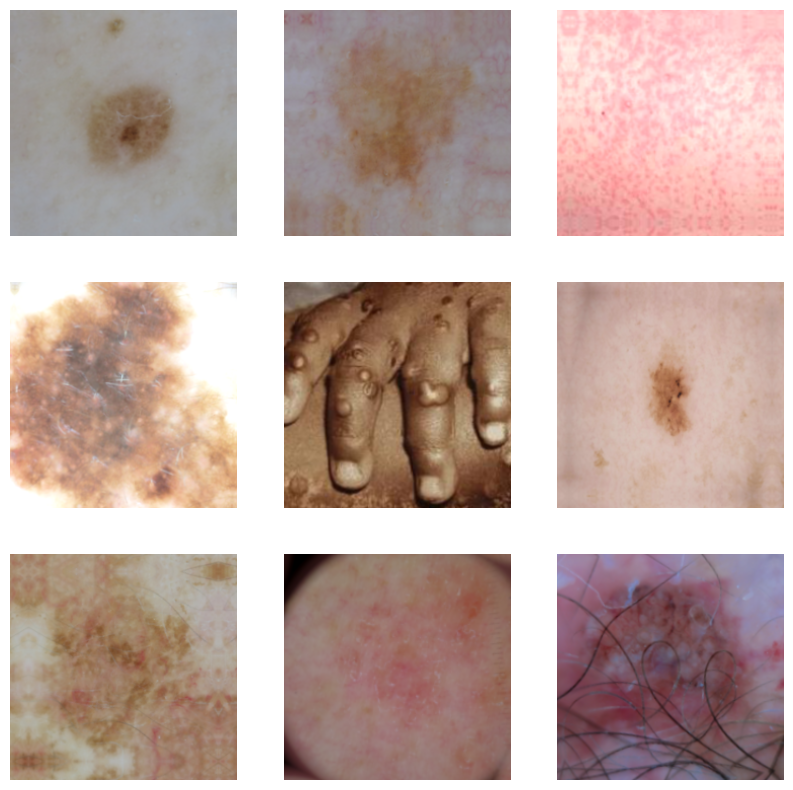

In [11]:
### DATA AUGMENTATION ###

# Define optimized augmentation layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),               # flipping
    RandomRotation(0.1),                     # Rotate
    RandomZoom(0.2),                         # Zoom in or out (20% max)
    RandomBrightness(0.001),            # Adjusting brightness (1%)
    RandomContrast(0.002),              # Adjusting contrast (2%)
])

# Augment training dataset
train_dataset_augmented = train_dataset_224.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Visualizing augmented images
for image_batch, label_batch in train_dataset_augmented.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = image_batch[i].numpy()
        img = tf.clip_by_value(img, 0.0, 1.0)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

In [6]:
### Functions for plotting and vizualizing the results ###

def plot_training_history(history, title=" "):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.suptitle(title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def visualize_predictions(model, dataset, num_images=5):
    """Visualize model predictions."""
    dataset_iter = iter(dataset.take(3))  # Taking one batch
    batch = next(dataset_iter)

    images, labels = batch  # Extract images and labels
    predictions = model.predict(images)

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)

        img = images[i].numpy()  # Convert tensor to NumPy array
        plt.imshow(img)

        predicted_class = np.argmax(predictions[i])
        true_class = labels[i].numpy()

        color = 'green' if predicted_class == true_class else 'red'
        plt.title(f'Pred: {predicted_class}\nTrue: {true_class}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Different models for the task a.

1. The basic model provided from the start.
2. Resnet inspired model
3. EfficientNet inspired model
4. Our expanded model, based on the simple basic model.
4. Comparing optimizers with our model
5. Comparing regularization methods
6. Adding Daata augmentation
7. Using Transfer learning

In [ ]:
#First CNN basic model - provided

TARGET_HEIGHT = 224
TARGET_WIDTH = 224

def first_ccn_model():
    input_img = Input(shape=(TARGET_HEIGHT,TARGET_WIDTH,3))

    x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
    x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    y = Dense(14, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model

sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)

model = first_ccn_model()

model.compile(optimizer=sgd_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_dataset_224,
                 validation_data=validation_dataset_224,
                 epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset_224)
print(f"Test accuracy: {test_acc}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


916/916 ━━━━━━━━━━━━━━━━━━━━ 182s 177ms/step - accuracy: 0.3481 - loss: 2.1320 - val_accuracy: 0.3862 - val_loss: 1.8973
Epoch 2/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - accuracy: 0.3952 - loss: 1.8593 - val_accuracy: 0.4444 - val_loss: 1.6813
Epoch 3/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.4296 - loss: 1.7169 - val_accuracy: 0.4570 - val_loss: 1.6143
Epoch 4/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 100s 106ms/step - accuracy: 0.4470 - loss: 1.6473 - val_accuracy: 0.4698 - val_loss: 1.6071
Epoch 5/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 103s 110ms/step - accuracy: 0.4616 - loss: 1.6049 - val_accuracy: 0.4890 - val_loss: 1.5400
Epoch 6/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 105s 112ms/step - accuracy: 0.4706 - loss: 1.5736 - val_accuracy: 0.4931 - val_loss: 1.5111
Epoch 7/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 101s 107ms/step - accuracy: 0.4750 - loss: 1.5447 - val_accuracy: 0.5036 - val_loss: 1.4922
Epoch 8/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 102s 108ms/step - accuracy: 0.4854 - loss: 1.512

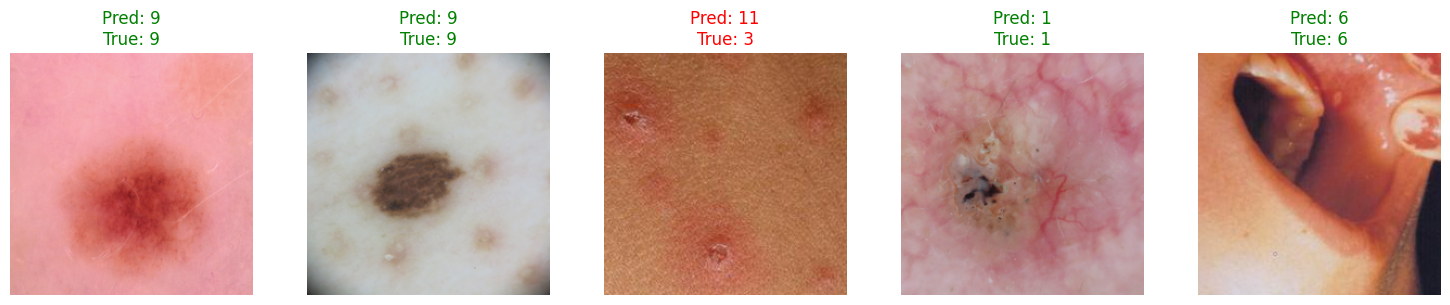

Plotting results...


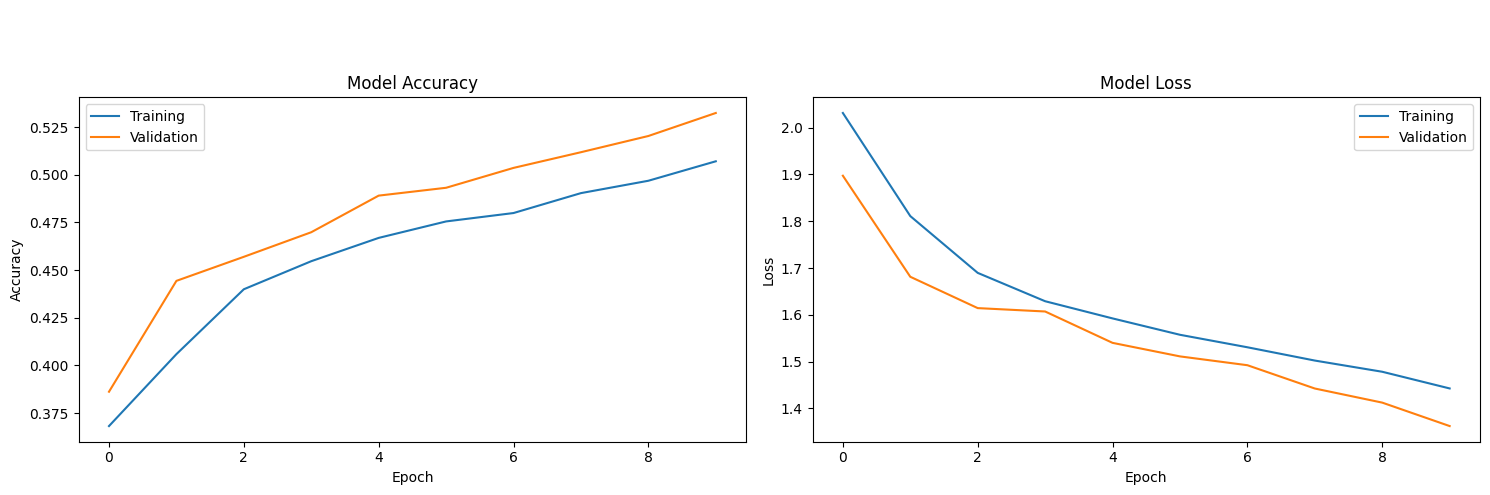

In [12]:

#Resnet inspired model
def bottleneck_block(x, filters):
    """Simple Bottleneck Residual Block"""

    shortcut = x  #input for the skip connection

    # 1x1 Conv
    x = Conv2D(filters // 4, (1, 1), padding='same', activation='relu')(x)

    # 3x3 Conv
    x = Conv2D(filters // 4, (3, 3), padding='same', activation='relu')(x)

    # 1x1 Conv
    x = Conv2D(filters, (1, 1), padding='same', activation=None)(x)

    # If input and output channel dimensions doesnt match, then we adjust shortcut, might need sdjustment
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same', activation=None)(shortcut)

    # Add shortcut (skip connection)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x


# Our ResNet-inspired model
def resnet_model():
    input_img = Input(shape=(224, 224, 3))

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
    x = bottleneck_block(x, 32)
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 128)
    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    y = Dense(14, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model

# Compile the model
sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)
model = resnet_model()
model.compile(optimizer=sgd_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
hist = model.fit(train_dataset_224,
                 validation_data=validation_dataset_224,
                 epochs=10)


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset_224)
print(f"Test accuracy: {test_acc}")

# Correct function call for predictions visualization
visualize_predictions(model, test_dataset_224, num_images=5)

# Correct function call for training visualization
print("Plotting results...")
plot_training_history(hist)




In [ ]:
resnet_model.summary

Epoch 1/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 109s 105ms/step - accuracy: 0.3481 - loss: 2.1897 - val_accuracy: 0.3517 - val_loss: 2.1174
Epoch 2/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 97s 102ms/step - accuracy: 0.3544 - loss: 2.1089 - val_accuracy: 0.3769 - val_loss: 2.0358
Epoch 3/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 97s 102ms/step - accuracy: 0.3747 - loss: 2.0383 - val_accuracy: 0.3758 - val_loss: 1.9956
Epoch 4/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 98s 104ms/step - accuracy: 0.3749 - loss: 2.0062 - val_accuracy: 0.3945 - val_loss: 1.8693
Epoch 5/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 97s 103ms/step - accuracy: 0.3968 - loss: 1.8632 - val_accuracy: 0.4208 - val_loss: 1.7718
Epoch 6/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 97s 103ms/step - accuracy: 0.4145 - loss: 1.7756 - val_accuracy: 0.4603 - val_loss: 1.6590
Epoch 7/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 97s 102ms/step - accuracy: 0.4367 - loss: 1.7025 - val_accuracy: 0.4567 - val_loss: 1.6512
Epoch 8/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 98s 103ms/step - accuracy: 0.4466 - loss: 

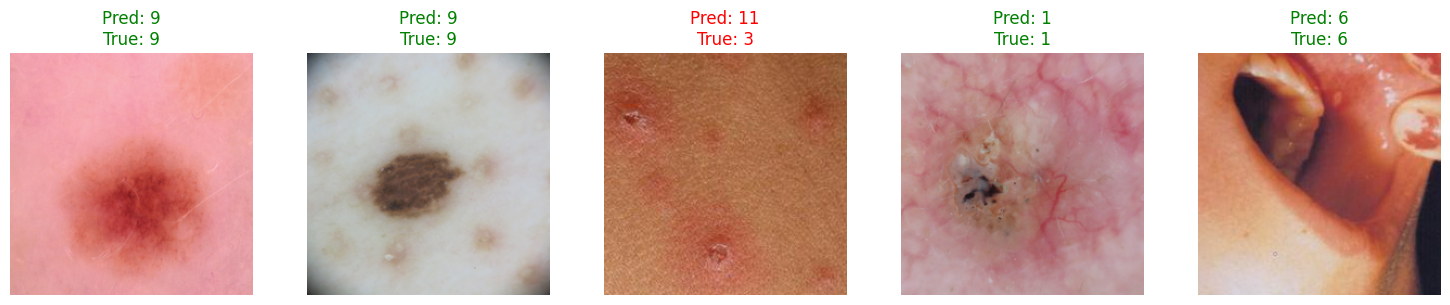

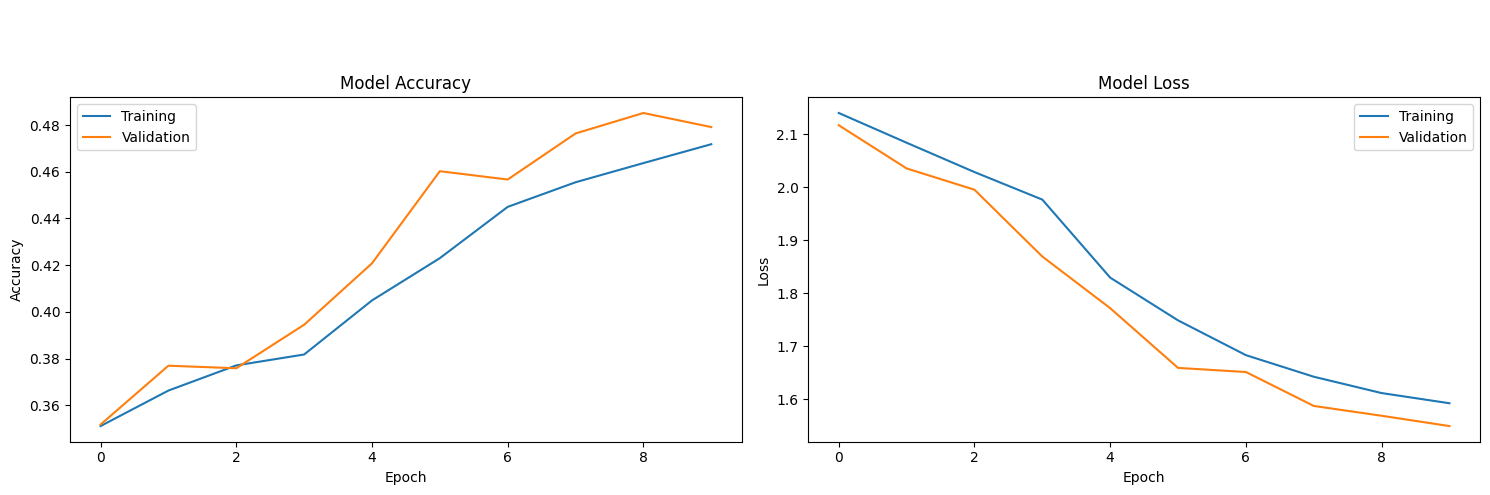

In [13]:
#EfficientNet inspired model architecture


# MBConv Block (inpired from EfficientNet)
def mbconv_block(x, filters, expansion_factor=4, kernel_size=(3, 3)):
    input_filters = x.shape[-1]

    expanded_filters = input_filters * expansion_factor

    x = Conv2D(expanded_filters, (1, 1), activation='relu')(x)

    x = DepthwiseConv2D(kernel_size=kernel_size, padding='same', activation='relu')(x)

    x = Conv2D(filters, (1, 1), activation=None)(x)

    if input_filters == filters:
        x = Add()([x, x])
    return x

# EfficientNet-inspired CNN
def efficientnet_model():
    input_img = Input(shape=(224, 224, 3))

    # Initial Conv Layer (Downsampling)
    x = Conv2D(32, (3, 3), strides=2, padding='same', activation=None)(input_img)

    # MBConv Blocks
    x = mbconv_block(x, 32)
    x = mbconv_block(x, 64)

    # Classification Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(14, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model


# Train EfficientNet-inspired model
sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)
model = efficientnet_model()
model.compile(optimizer=sgd_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_dataset_224,
                 validation_data=validation_dataset_224,
                 epochs=10)

# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset_224)
print(f"EfficientNet Test Accuracy: {test_acc}")

# Correct function call for predictions visualization
visualize_predictions(model, test_dataset_224, num_images=5)

# Correct function call for training visualization
plot_training_history(hist)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


916/916 ━━━━━━━━━━━━━━━━━━━━ 924s 1s/step - accuracy: 0.3501 - loss: 2.1229 - val_accuracy: 0.4172 - val_loss: 1.7756
Epoch 2/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 182s 197ms/step - accuracy: 0.4183 - loss: 1.7738 - val_accuracy: 0.4485 - val_loss: 1.6218
Epoch 3/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 180s 194ms/step - accuracy: 0.4568 - loss: 1.6146 - val_accuracy: 0.4855 - val_loss: 1.5404
Epoch 4/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 181s 195ms/step - accuracy: 0.4847 - loss: 1.5187 - val_accuracy: 0.4951 - val_loss: 1.4773
Epoch 5/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 182s 197ms/step - accuracy: 0.5126 - loss: 1.4262 - val_accuracy: 0.5110 - val_loss: 1.4245
Epoch 6/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 180s 195ms/step - accuracy: 0.5446 - loss: 1.3272 - val_accuracy: 0.5471 - val_loss: 1.3209
Epoch 7/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 182s 196ms/step - accuracy: 0.5673 - loss: 1.2365 - val_accuracy: 0.5721 - val_loss: 1.2220
Epoch 8/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 185s 199ms/step - accuracy: 0.5851 - loss: 1.1685 

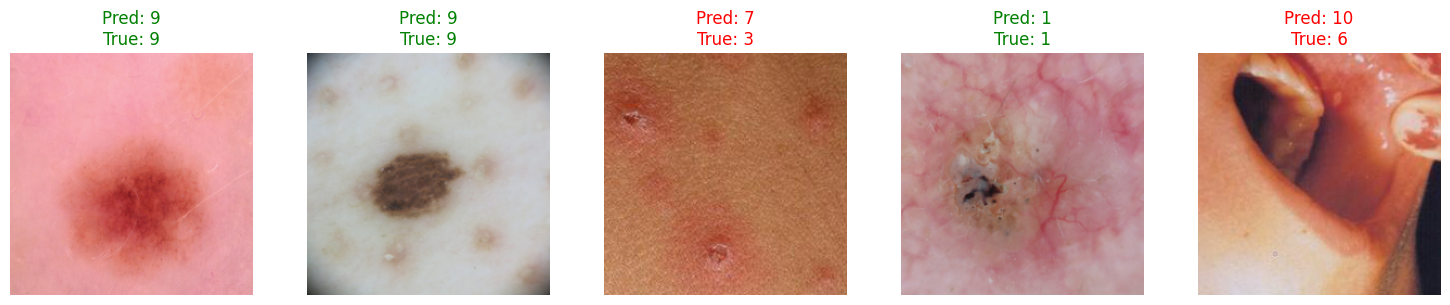

Plotting results...


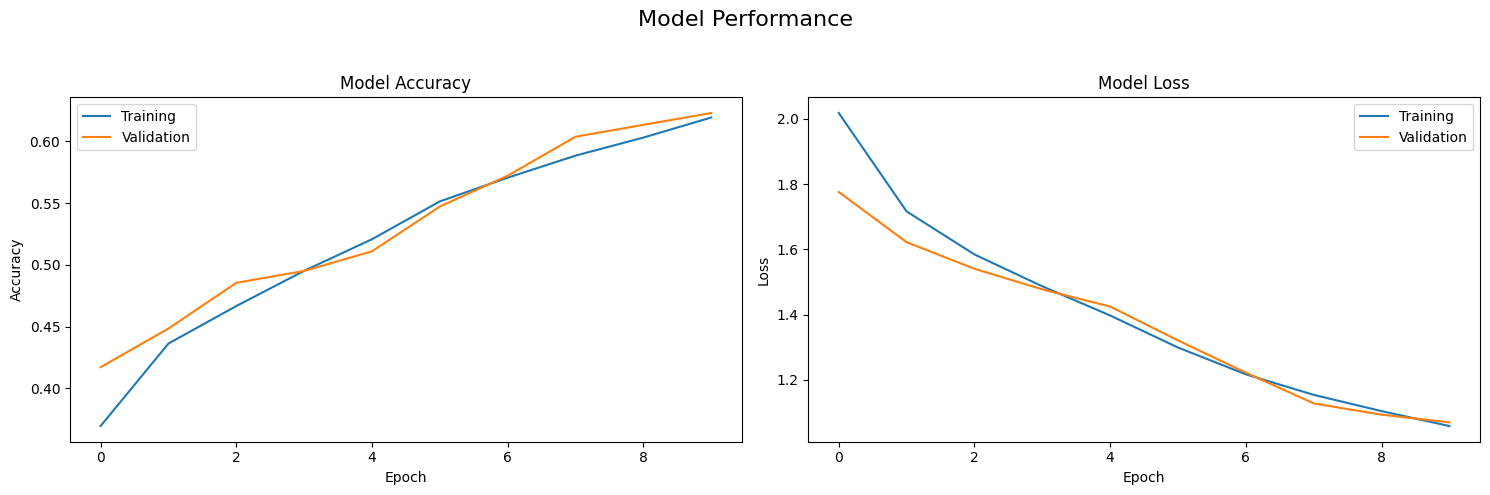

In [ ]:
### Our expansion of the basic model ###

#Using same structure as the CNN assignment as a baseline for the structure.

# Define the model
model = Sequential([

    # Initial Conv Layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),


    # Conv Block 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),


    # Conv Block 2
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


    # Conv Block 3
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),


    # Fully Connected Layer
    Dense(128, activation='relu'),

    # Output Layer (14 classes)
    Dense(14, activation='softmax'),
])

# Compile the model
sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)

model.compile(optimizer=sgd_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
hist = model.fit(train_dataset_224,
                 validation_data=validation_dataset_224,
                 epochs=10,
                 callbacks=[early_stopping])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset_224)
print(f"Test accuracy: {test_acc}")

# Correct function call for predictions visualization
visualize_predictions(model, test_dataset_224, num_images=5)

# Correct function call for training visualization
print("Plotting results...")
plot_training_history(hist, title="Model Performance")




 Training with SGD optimizer...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
916/916 ━━━━━━━━━━━━━━━━━━━━ 842s 913ms/step - accuracy: 0.3521 - loss: 2.1423 - val_accuracy: 0.3832 - val_loss: 1.8952
Epoch 2/7
916/916 ━━━━━━━━━━━━━━━━━━━━ 183s 198ms/step - accuracy: 0.3952 - loss: 1.8575 - val_accuracy: 0.4474 - val_loss: 1.6423
Epoch 3/7
916/916 ━━━━━━━━━━━━━━━━━━━━ 186s 200ms/step - accuracy: 0.4483 - loss: 1.6527 - val_accuracy: 0.4611 - val_loss: 1.6030
Epoch 4/7
916/916 ━━━━━━━━━━━━━━━━━━━━ 187s 202ms/step - accuracy: 0.4796 - loss: 1.5446 - val_accuracy: 0.4759 - val_loss: 1.5500
Epoch 5/7
916/916 ━━━━━━━━━━━━━━━━━━━━ 187s 201ms/step - accuracy: 0.5054 - loss: 1.4535 - val_accuracy: 0.5027 - val_loss: 1.4586
Epoch 6/7
916/916 ━━━━━━━━━━━━━━━━━━━━ 194s 210ms/step - accuracy: 0.5292 - loss: 1.3720 - val_accuracy: 0.5348 - val_loss: 1.3366
Epoch 7/7
916/916 ━━━━━━━━━━━━━━━━━━━━ 215s 233ms/step - accuracy: 0.5557 - loss: 1.2894 - val_accuracy: 0.5800 - val_loss: 1.1949
29/29 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.5933 - loss: 1.1352
Test Accu

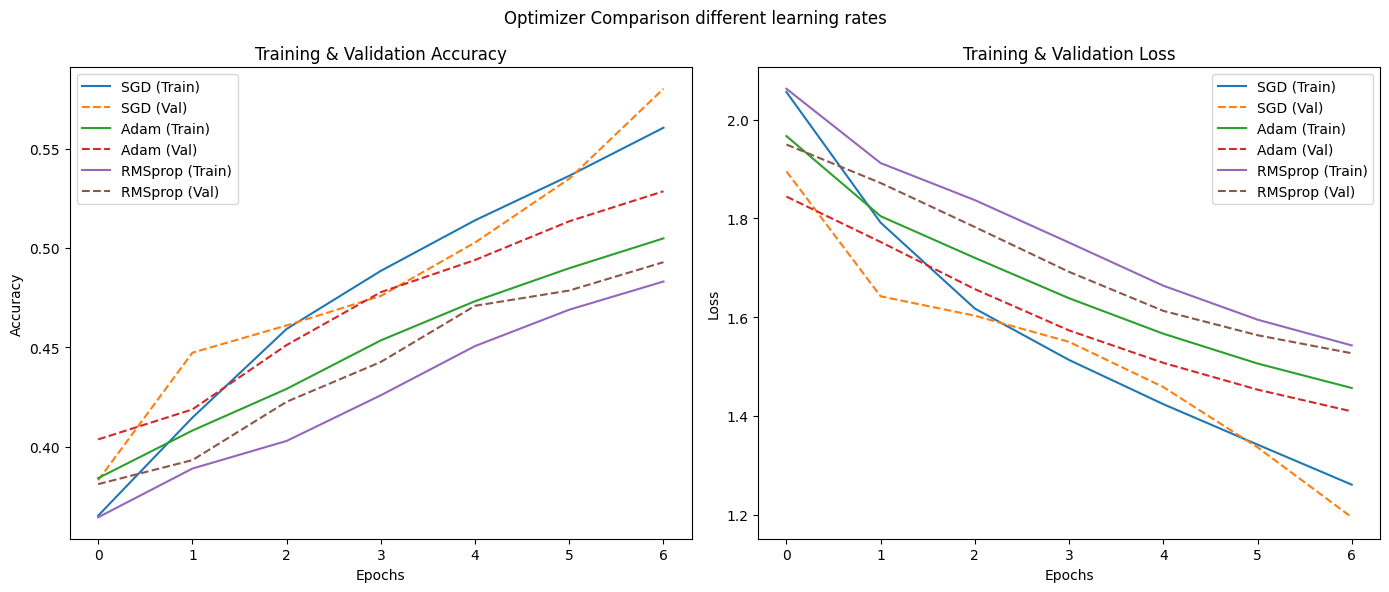

📁 Plot saved to: /content/drive/My Drive/DS807/optimizer_comparison.png


In [13]:
# Define optimizers to test
optimizers = {
    "SGD": SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    "Adam": Adam(learning_rate=0.0001),
    "RMSprop": RMSprop(learning_rate=0.0001, rho=0.9)
}

# Dictionary to store training history
histories = {}

def create_cnn_model():
    model = Sequential([
        # Initial Conv Layer
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2)),

        # Conv Block 1
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Conv Block 2
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Conv Block 3
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),

        # Fully Connected Layer
        Dense(128, activation='relu'),


        # Output Layer (14 classes)
        Dense(14, activation='softmax'),
    ])
    return model



# Train the model with different optimizers
for opt_name, optimizer in optimizers.items():
    print(f"\n Training with {opt_name} optimizer...\n")

    # Create a new model instance for each optimizer
    model = create_cnn_model()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    hist = model.fit(train_dataset_224,
                     validation_data=validation_dataset_224,
                     epochs=7,
                     callbacks=[early_stopping])

    # Store history
    histories[opt_name] = hist.history

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(test_dataset_224)
    print(f"Test Accuracy with {opt_name}: {test_acc:.4f}")

# Function to plot optimizer comparison
def plot_optimizer_comparison(histories, file_path):
    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for opt_name, history in histories.items():
        plt.plot(history['accuracy'], label=f"{opt_name} (Train)")
        plt.plot(history['val_accuracy'], linestyle='dashed', label=f"{opt_name} (Val)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    for opt_name, history in histories.items():
        plt.plot(history['loss'], label=f"{opt_name} (Train)")
        plt.plot(history['val_loss'], linestyle='dashed', label=f"{opt_name} (Val)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Overall title
    plt.suptitle("Optimizer Comparison different learning rates")

    plt.tight_layout()

    # Save the combined figure
    save_file = os.path.join(file_path, "optimizer_comparison.png")
    plt.savefig(save_file)
    plt.show()

    print(f" Plot saved to: {save_file}")

# Call the function and save results
plot_optimizer_comparison(histories, filepath)


Training: Dropout

Epoch 1/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 737s 796ms/step - accuracy: 0.3461 - loss: 2.1748 - val_accuracy: 0.3681 - val_loss: 2.0377
Epoch 2/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 204s 219ms/step - accuracy: 0.3797 - loss: 1.9783 - val_accuracy: 0.4068 - val_loss: 1.7956
Epoch 3/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 206s 221ms/step - accuracy: 0.4046 - loss: 1.8092 - val_accuracy: 0.4468 - val_loss: 1.6621
Epoch 4/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 206s 222ms/step - accuracy: 0.4301 - loss: 1.6974 - val_accuracy: 0.4762 - val_loss: 1.5480
Epoch 5/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 206s 221ms/step - accuracy: 0.4565 - loss: 1.6169 - val_accuracy: 0.5036 - val_loss: 1.4632
Epoch 6/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 206s 222ms/step - accuracy: 0.4830 - loss: 1.5358 - val_accuracy: 0.5260 - val_loss: 1.3835
Epoch 7/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 205s 221ms/step - accuracy: 0.5063 - loss: 1.4505 - val_accuracy: 0.5477 - val_loss: 1.3019
Epoch 8/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 206s 221ms/step 

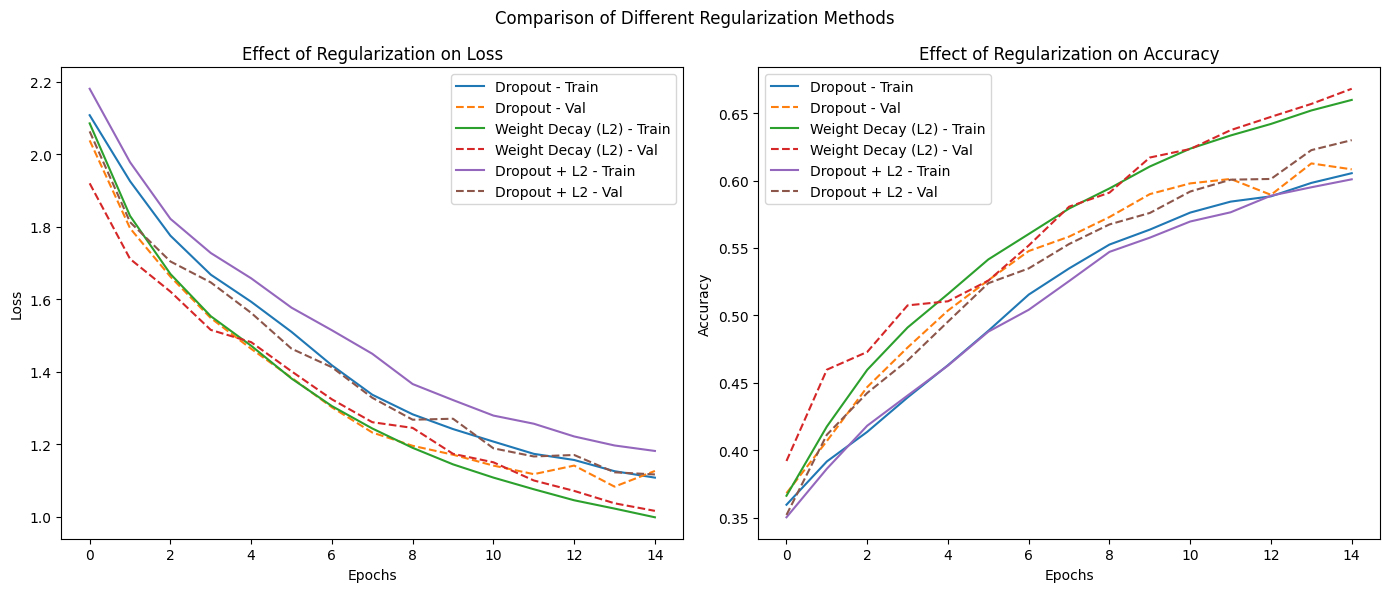

In [8]:
### Comparing regularization methods ###

histories = {}
labels = {}

# Function to build model with different regularization methods
def build_model(dropout_rate=0.5, l2_lambda=0.0001):
    model = Sequential([
        Input(shape=(224, 224, 3)),  # Input Layer

        # Initial Conv Layer
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Conv Block 1
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda)),
        MaxPooling2D(pool_size=(2, 2)),

        # Conv Block 2
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Conv Block 3
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda)),
        GlobalAveragePooling2D(),

        # Fully Connected Layer
        Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),

        # Output Layer (14 classes)
        Dense(14, activation='softmax'),
    ])
    return model

# Define training function
def train_and_store_model(model, label, epochs=15, patience=3):
    sgd_opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd_opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    print(f"\nTraining: {label}\n")
    history = model.fit(train_dataset_224, validation_data=validation_dataset_224, epochs=epochs, callbacks=[early_stopping])

    # Store history
    histories[label] = history
    labels[label] = label

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_dataset_224)
    print(f"{label} Test Accuracy: {test_acc:.4f}")



#Train the different models with different regularization methods

# Dropout Model (Your Existing Model)
dropout_model = build_model(dropout_rate=0.5, l2_lambda=0)
train_and_store_model(dropout_model, "Dropout")

# Weight Decay (L2 Regularization)
l2_model = build_model(dropout_rate=0, l2_lambda=0.0001)
train_and_store_model(l2_model, "Weight Decay (L2)")

# Both togehter Model (Dropout + L2)
early_stopping_model = build_model(dropout_rate=0.5, l2_lambda=0.0001)
train_and_store_model(early_stopping_model, "Dropout + L2")

# Function to Plot Regularization Comparison
def plot_regularization_comparison(histories, labels):
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    for key in histories.keys():
        plt.plot(histories[key].history['loss'], label=f'{labels[key]} - Train')
        plt.plot(histories[key].history['val_loss'], linestyle='dashed', label=f'{labels[key]} - Val')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Effect of Regularization on Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for key in histories.keys():
        plt.plot(histories[key].history['accuracy'], label=f'{labels[key]} - Train')
        plt.plot(histories[key].history['val_accuracy'], linestyle='dashed', label=f'{labels[key]} - Val')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Effect of Regularization on Accuracy")
    plt.legend()

    plt.suptitle("Comparison of Different Regularization Methods")
    plt.tight_layout()
    plt.show()

# Call function to visualize
plot_regularization_comparison(histories, labels)


In [ ]:
### ADDING DATA AUGMENTATION ###

# Function to create model
def build_model():
    model = Sequential([
        Input(shape=(224, 224, 3)),

        # Initial Conv Layer
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Conv Block 1
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
        MaxPooling2D(pool_size=(2, 2)),

        # Conv Block 2
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Conv Block 3
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
        GlobalAveragePooling2D(),

        # Fully Connected Layer
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),

        # Output Layer (14 classes)
        Dense(14, activation='softmax'),
    ])
    return model

# Compile function
def compile_model(model):
    sgd_opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd_opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train function
def train_model(model, train_dataset, validation_dataset, epochs=20):
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs=epochs,
                        callbacks=[early_stopping])
    return history


# Train model without augmentation
print("\nTraining model WITHOUT data augmentation...\n")
model_no_aug = build_model()
model_no_aug = compile_model(model_no_aug)
history_no_aug = train_model(model_no_aug, train_dataset_224, validation_dataset_224)

# Train model with augmentation
print("\nTraining model WITH data augmentation...\n")
model_with_aug = build_model()
model_with_aug = compile_model(model_with_aug)
history_with_aug = train_model(model_with_aug, train_dataset_augmented, validation_dataset_224)

# Evaluate both models
test_loss_no_aug, test_acc_no_aug = model_no_aug.evaluate(test_dataset_224)
test_loss_with_aug, test_acc_with_aug = model_with_aug.evaluate(test_dataset_224)

print(f"Test accuracy without augmentation: {test_acc_no_aug:.4f}")
print(f"Test accuracy with augmentation: {test_acc_with_aug:.4f}")

# Function to plot comparison
def plot_training_comparison(hist_no_aug, hist_with_aug):
    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(hist_no_aug.history['accuracy'], label="No Aug - Train", linestyle='solid')
    plt.plot(hist_no_aug.history['val_accuracy'], label="No Aug - Val", linestyle='dashed')
    plt.plot(hist_with_aug.history['accuracy'], label="Aug - Train", linestyle='solid')
    plt.plot(hist_with_aug.history['val_accuracy'], label="Aug - Val", linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Effect of Data Augmentation on Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(hist_no_aug.history['loss'], label="No Aug - Train", linestyle='solid')
    plt.plot(hist_no_aug.history['val_loss'], label="No Aug - Val", linestyle='dashed')
    plt.plot(hist_with_aug.history['loss'], label="Aug - Train", linestyle='solid')
    plt.plot(hist_with_aug.history['val_loss'], label="Aug - Val", linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Effect of Data Augmentation on Loss")
    plt.legend()

    plt.suptitle("Comparison of Models With and Without Data Augmentation")
    plt.tight_layout()
    plt.show()

# Plot results
plot_training_comparison(history_no_aug, history_with_aug)



Model Summary:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 14)                  │           3,598 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,101,134 (91.94 MB)

 Trainable params: 532,238 (2.03 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

Epoch 1/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 115s 114ms/step - accuracy: 0.5500 - loss: 1.5587 - val_accuracy: 0.6974 - val_loss: 0.9009
Epoch 2/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 108s 113ms/step - accuracy: 0.6591 - loss: 1.0632 - val_accuracy: 0.7113 - val_loss: 0.8858
Epoch 3/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 107s 112ms/step - accuracy: 0.6762 - loss: 0.9971 - val_accuracy: 0.7300 - val_loss: 0.8537
Epoch 4/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 108s 113ms/step - accuracy: 0.6910 - loss: 0.9861 - val_accuracy: 0.7377 - val_loss: 0.8431
Epoch 5/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 110s 115ms/step - accuracy: 0.6994 - loss: 0.9728 - val_accuracy: 0.7431 - val_loss: 0.8513
Epoch 6/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 109s 115ms/step - accuracy: 0.7071 - loss: 0.9705 - val_accuracy: 0.7445 - val_loss: 0.8444
Epoch 7/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 108s 113ms/step - accuracy: 0.7063 - loss: 0.9680 - val_accuracy: 0.7470 - val_loss: 0.8465
Epoch 8/50
916/916 ━━━━━━━━━━━━━━━━━━━━ 108s 113ms/step - accuracy: 0.7118 -

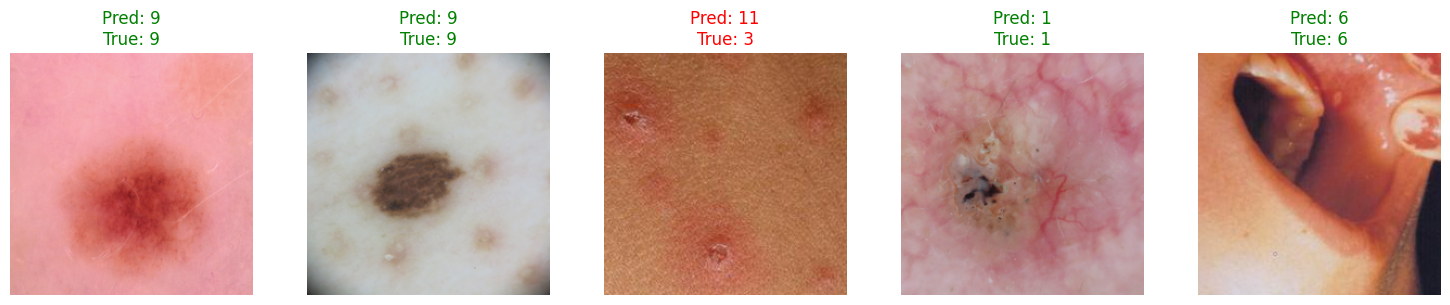

Plotting results...


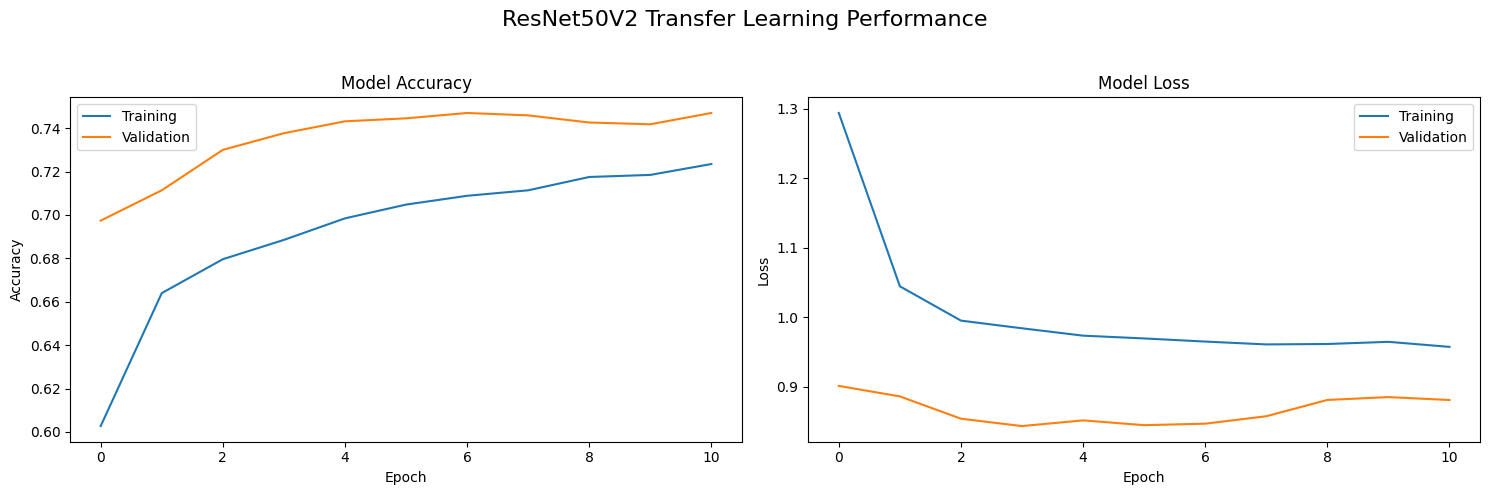

In [22]:
### Tranfer learning ###

# Import ResNet50V2
from tensorflow.keras.applications import ResNet50V2


# Using same approach as in exercise, so remember Adam as optimizer.

# Function to create the model
def create_transfer_learning_model(num_classes):

    # Loading ResNet50V2 with pre-trained ImageNet weights
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Define the new model
    model = Sequential([
        # Input layer
        Input(shape=(224, 224, 3)),

        # Pretrained ResNet50V2
        base_model,

        # Global Average Pooling instead of Flatten
        GlobalAveragePooling2D(),

        # Batch Normalization for stability
        BatchNormalization(),

        # Fully Connected Layer with L2 regularization
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.5),  # Dropout for regularization

        # Output layer with softmax activation
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to train the model
def train_model(model, train_ds, val_ds, epochs=50):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    return history

# Number of classes in the dataset
num_classes = 14

# Create and train model
model = create_transfer_learning_model(num_classes)

# Print model summary
print("\nModel Summary:")
model.summary()

# Train the model
hist = train_model(model, train_dataset_augmented, validation_dataset_224, epochs=50)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset_224)
print(f"Test accuracy: {test_acc}")

# Visualize predictions
visualize_predictions(model, test_dataset_224, num_images=5)

# Plot training history
print("Plotting results...")
plot_training_history(hist, title="ResNet50V2 Transfer Learning Performance")

In [71]:
model.summary()  # Look for the last Conv2D layer, typically "conv5_block3_out" in ResNet50V2
for layer in model.layers[0].layers:  # Extracting from ResNet50V2 inside Sequential
    print(layer.name)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 14)                  │           3,598 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,165,612 (96.00 MB)

 Trainable params: 532,238 (2.03 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

 Optimizer params: 1,064,478 (4.06 MB)

input_layer_16
conv1_pad
conv1_conv
pool1_pad
pool1_pool
conv2_block1_preact_bn
conv2_block1_preact_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_pad
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_out
conv2_block2_preact_bn
conv2_block2_preact_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_pad
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_out
conv2_block3_preact_bn
conv2_block3_preact_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_pad
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
max_pooling2d_15
conv2_block3_3_conv
conv2_block3_out
conv3_block1_preact_bn
conv3_block1_preact_relu
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_pad
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_out
conv3_

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


916/916 ━━━━━━━━━━━━━━━━━━━━ 613s 665ms/step - accuracy: 0.3431 - loss: 2.1810 - val_accuracy: 0.3671 - val_loss: 1.9548
Epoch 2/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 195s 209ms/step - accuracy: 0.3675 - loss: 2.0042 - val_accuracy: 0.3986 - val_loss: 1.8561
Epoch 3/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 200s 215ms/step - accuracy: 0.3927 - loss: 1.8829 - val_accuracy: 0.4304 - val_loss: 1.7686
Epoch 4/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 204s 218ms/step - accuracy: 0.4248 - loss: 1.7800 - val_accuracy: 0.4671 - val_loss: 1.6407
Epoch 5/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 204s 219ms/step - accuracy: 0.4540 - loss: 1.6818 - val_accuracy: 0.4690 - val_loss: 1.6077
Epoch 6/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 202s 217ms/step - accuracy: 0.4712 - loss: 1.6165 - val_accuracy: 0.5129 - val_loss: 1.4682
Epoch 7/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 202s 216ms/step - accuracy: 0.5003 - loss: 1.5212 - val_accuracy: 0.5419 - val_loss: 1.3678
Epoch 8/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 204s 219ms/step - accuracy: 0.5293 - loss: 1.39

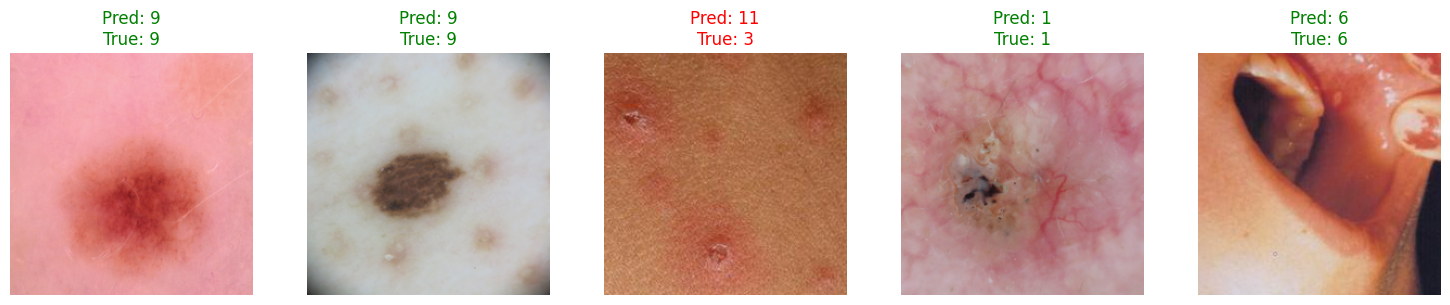

Plotting results...


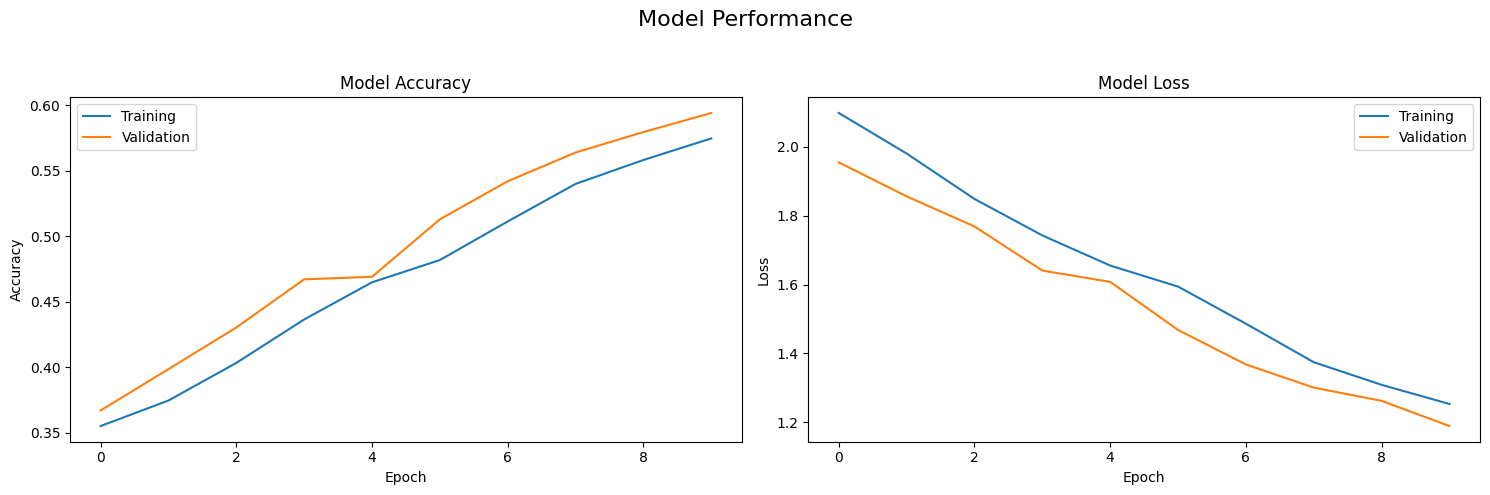

In [74]:
### Running the model from before with data augmentation, since we couldnt extract last layer from the transfer model###

# Function to create model
def build_model():
    model = Sequential([
        Input(shape=(224, 224, 3)),

        # Initial Conv Layer
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Conv Block 1
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
        MaxPooling2D(pool_size=(2, 2)),

        # Conv Block 2
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Conv Block 3
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
        GlobalAveragePooling2D(),

        # Fully Connected Layer
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),

        # Output Layer (14 classes)
        Dense(14, activation='softmax'),
    ])
    return model

# Compile the model
sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)

model_1 = build_model()
model_1.compile(optimizer=sgd_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
hist = model_1.fit(train_dataset_augmented,
                 validation_data=validation_dataset_224,
                 epochs=10,
                 callbacks=[early_stopping])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset_224)
print(f"Test accuracy: {test_acc}")

# Correct function call for predictions visualization
visualize_predictions(model, test_dataset_224, num_images=5)

# Correct function call for training visualization
print("Plotting results...")
plot_training_history(hist, title="Model Performance")

In [77]:
last_conv_layer_name = "conv2d_3"  # thinking this is the last layer from this model

def get_heatmap(category, start_image, model, last_conv_layer_name, output_layer_name):
    # Extract required layers
    output_layer = model.get_layer(output_layer_name).output
    last_conv_layer = model.get_layer(last_conv_layer_name).output

    # Create submodel for Grad-CAM
    submodel = tf.keras.models.Model([model.inputs], [output_layer, last_conv_layer])

    # Convert image to TensorFlow Variable
    input_img_data = tf.Variable(tf.cast(start_image, tf.float32))

    with tf.GradientTape() as tape:
        outputs_class, outputs_conv = submodel(input_img_data)
        loss_value = tf.reduce_mean(outputs_class[:, category])

    grads = tape.gradient(loss_value, outputs_conv)

    # Guided Backpropagation
    cast_outputs_conv = tf.cast(outputs_conv > 0, "float32")
    cast_grads = tf.cast(grads > 0, "float32")
    guided_grads = cast_outputs_conv * cast_grads * grads

    # Compute weights
    outputs_conv = outputs_conv[0]
    guided_grads = guided_grads[0]
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Compute Class Activation Map
    cam = tf.reduce_sum(tf.multiply(weights, outputs_conv), axis=-1)

    return cam.numpy()


In [92]:
# Extract the image and label from the test dataset
for test_image, test_label in test_dataset_224.take(1):
    sample_image = test_image.numpy()  # Converting it to NumPy array
    sample_label = test_label.numpy()
    break

# Expand dimensions to match model input
sample_image_expanded = np.expand_dims(sample_image[0], axis=0)


In [93]:
cmap = plt.get_cmap('jet')

def create_heatmap(image, category, model, last_conv_layer_name, output_layer_name):

    heatmap = get_heatmap(category, image, model, last_conv_layer_name, output_layer_name)
    heatmap = Image.fromarray(heatmap)
    heatmap = heatmap.resize((224, 224), Image.LANCZOS)
    heatmap = np.array(heatmap)
    heatmap = heatmap / heatmap.max()
    heatmap = cmap(heatmap)
    heatmap = np.delete(heatmap, 3, 2)

    overlayed_heatmap = 0.6 * image[0] + 0.4 * heatmap

    return image[0], heatmap, overlayed_heatmap

# Plot Heatmap
def plot_heatmap(image, label, model, last_conv_layer_name, output_layer_name):
    plt.figure(figsize=(7, 7))
    images = create_heatmap(image, label, model, last_conv_layer_name, output_layer_name)

    titles = ["Original Image", "Heatmap", "Overlayed Heatmap"]
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.axis('off')
        plt.title(titles[i])
        plt.imshow(images[i])

    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1466']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


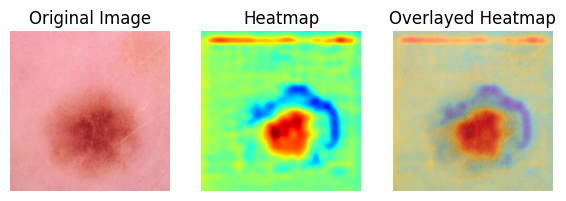

In [94]:
# Grad-CAM visualization
plot_heatmap(sample_image_expanded, sample_label[0], model_1,
             last_conv_layer_name="conv2d_32",
             output_layer_name="dense_21")
